### Some installations

In [1]:
pip install pennylane

Note: you may need to restart the kernel to use updated packages.


In [27]:
pip install pennylane pennylane-qiskit


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pennylane pennylane-qiskit qiskit qiskit-ibm-runtime

  Using cached qiskit-1.2.4-cp38-abi3-win_amd64.whl.metadata (13 kB)
  Using cached qiskit_ibm_runtime-0.29.0-py3-none-any.whl.metadata (19 kB)
Using cached qiskit-1.2.4-cp38-abi3-win_amd64.whl (4.6 MB)
Using cached qiskit_ibm_runtime-0.29.0-py3-none-any.whl (2.9 MB)
  Attempting uninstall: qiskit
    Found existing installation: qiskit 1.3.1
    Uninstalling qiskit-1.3.1:
      Successfully uninstalled qiskit-1.3.1
  Attempting uninstall: qiskit-ibm-runtime
    Found existing installation: qiskit-ibm-runtime 0.34.0
    Uninstalling qiskit-ibm-runtime-0.34.0:
      Successfully uninstalled qiskit-ibm-runtime-0.34.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install qiskit_aer

Note: you may need to restart the kernel to use updated packages.


### Necessary Imports

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService
import math
import random
import pennylane as qml
from pennylane import numpy as np
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np
from math import gcd
from sympy import isprime
from random import randint

### Generating RSA Keys

In [5]:
def generate_rsa_keys(bits=1024):
    """Generate an RSA public and private key pair."""
    # Step 1: Generate two large primes, p and q
    p = q = 1
    while not isprime(p):
        p = randint(2**(bits-1), 2**bits)
    while not isprime(q) or p == q:
        q = randint(2**(bits-1), 2**bits)
    
    # Step 2: Compute modulus N = p * q
    N = p * q
    
    # Step 3: Choose a public exponent e (usually 65537)
    e = 65537
    
    # Step 4: Compute private key d such that e * d ≡ 1 (mod (p-1)*(q-1))
    phi = (p-1)*(q-1)
    d = pow(e, -1, phi)
    
    # Public key is (N, e)
    # Private key is (N, d)
    
    return (N, e), (N, d), p, q

# Example RSA Key Generation
public_key, private_key, p, q = generate_rsa_keys(bits=10)  # Use smaller bits for simplicity in testing

print(f"Public Key (N, e): {public_key}")
print(f"Private Key (N, d): {private_key}")
print(f"Prime factors (p, q): {p}, {q}")


Public Key (N, e): (776981, 65537)
Private Key (N, d): (776981, 611873)
Prime factors (p, q): 1021, 761


### Connecting to an IBM Server

In [268]:
TOK = "your-token"


# Save with a different name
QiskitRuntimeService.save_account(
    channel="ibm_quantum", 
    token=TOK, 
    name="here-lil"  # New unique account name
)

In [269]:
service = QiskitRuntimeService(channel="ibm_quantum")


In [270]:
backends = service.backends()
for backend in backends:
    print(backend.name)

ibm_brisbane
ibm_kyiv
ibm_sherbrooke


In [ ]:
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=4)

### Getting started with pennylane

#### 1. Classical Implementation of Shor's Algorithm

In [6]:
def gcd(a, b):
    """Compute the greatest common divisor using the Euclidean algorithm."""
    while b:
        a, b = b, a % b
    return a

def find_period(a, N):
    """Classically find the period r of the function f(x) = a^x mod N."""
    r = 1
    result = a % N
    while result != 1:
        result = (result * a) % N
        r += 1
        # Stop if r becomes unreasonably large
        if r > N:
            return None
    return r

def shors_algorithm(N):
    """Classical simulation of Shor's Algorithm."""
    if N <= 1:
        return "Invalid input: N must be greater than 1."
    if N % 2 == 0:
        return (2, N // 2)

    while True:
        # Step 1: Pick a random integer a
        a = random.randint(2, N - 1)

        # Step 2: Check if gcd(a, N) > 1
        gcd_a_N = gcd(a, N)
        if gcd_a_N > 1:
            return (gcd_a_N, N // gcd_a_N)

        # Step 3: Find the period r of f(x) = a^x mod N
        r = find_period(a, N)
        if r is None:
            continue

        # Step 4: Check if r is even and a^(r/2) != -1 mod N
        if r % 2 == 0:
            x = pow(a, r // 2, N)
            if x != N - 1:
                # Compute the factors
                p = gcd(x - 1, N)
                q = gcd(x + 1, N)
                if p * q == N:
                    return (p, q)

In [7]:
a = 12
N = 644219 # the key generated from the rsa
params = [N, a]
wires = 10 + int(np.ceil(np.log2(N)))  # 10 estimated qubits for computing the period (r) 

result = shors_algorithm(N)
result

(919, 701)

### Testing Classical Shor with RSA

In [8]:
def rsa_test_with_shor():
    # Generate RSA keys
    public_key, private_key, p, q = generate_rsa_keys(bits=8)  # Use smaller bits for testing
    
    N = public_key[0]
    e = public_key[1]
    
    print(f"Generated RSA Public Key: N = {N}, e = {e}")
    print(f"RSA private key: (N, d) = {private_key}")
    
    # Use Shor's algorithm to try and factor N
    factors = shors_algorithm(N)
    if factors:
        print(f"Shor's Algorithm successfully factored N = {N} into: {factors}")
        # Check if the factors match the RSA primes
        if factors[0] == p and factors[1] == q or factors[0] == q and factors[1] == p:
            print(f"Factorization successful: p = {p}, q = {q}")
        else:
            print("Shor's Algorithm did not find the correct prime factors.")
    else:
        print("Shor's Algorithm failed to factor N.")



In [9]:
rsa_test_with_shor()

Generated RSA Public Key: N = 38191, e = 65537
RSA private key: (N, d) = (38191, 35873)
Shor's Algorithm successfully factored N = 38191 into: (181, 211)
Factorization successful: p = 211, q = 181


#### 2. Quantum Implementation of the Shor Algorithm 

In [181]:
# Define the parameters
a = 12
N = 35
params = [N, a]
wires = 10 + int(np.ceil(np.log2(N)))  # 10 estimation qubits + target qubits for log2(N)

In [237]:
nEstimateQUBITS = 10
estWIRES = range(nEstimateQUBITS)

In [238]:
# Helper function to construct the modular multiplication unitary
def _GetU_NA(a, N):
    nQ = int(np.ceil(np.log2(N)))
    uNA = np.zeros([2**nQ, 2**nQ])
    for k in range(N):
        uNA[(k * a) % N, k] = 1
    for extra in range(N, 2**nQ):
        uNA[extra, extra] = 1
    return uNA

# Define Shor's algorithm circuit
def ShorsCircuit(params):
    N, a = int(params[0]), int(params[1])
    uNA = _GetU_NA(a, N)
    nTargetQUBITS = int(np.ceil(np.log2(N)))
    tQ = nEstimateQUBITS + nTargetQUBITS
    tWAIRES = range(nEstimateQUBITS, tQ)
    
    # Target register initialization
    qml.PauliX(wires=tWAIRES[-1])
    
    # Apply Hadamard gates to the estimation qubits
    for wire in estWIRES:
        qml.Hadamard(wires=wire)
    
    # Controlled modular multiplication gates
    for i, wire in enumerate(estWIRES):
        power = 2 ** (nEstimateQUBITS - i - 1)
        qml.ControlledQubitUnitary(
            qml.math.linalg.matrix_power(uNA, power), 
            control_wires=[wire], 
            wires=tWAIRES
        )
    
    # Apply the inverse QFT to the estimation qubits
    qml.adjoint(qml.QFT)(wires=estWIRES)
    
    # Sampling the results
    return qml.sample()


#### Locally running the circuit

In [239]:
# Define the device
dev = qml.device("default.qubit", wires=wires)

In [247]:
# Quantum function
@qml.qnode(dev)
def circuit():
    ShorsCircuit(params)
    return qml.sample()

(<Figure size 1500x1500 with 1 Axes>, <Axes: >)

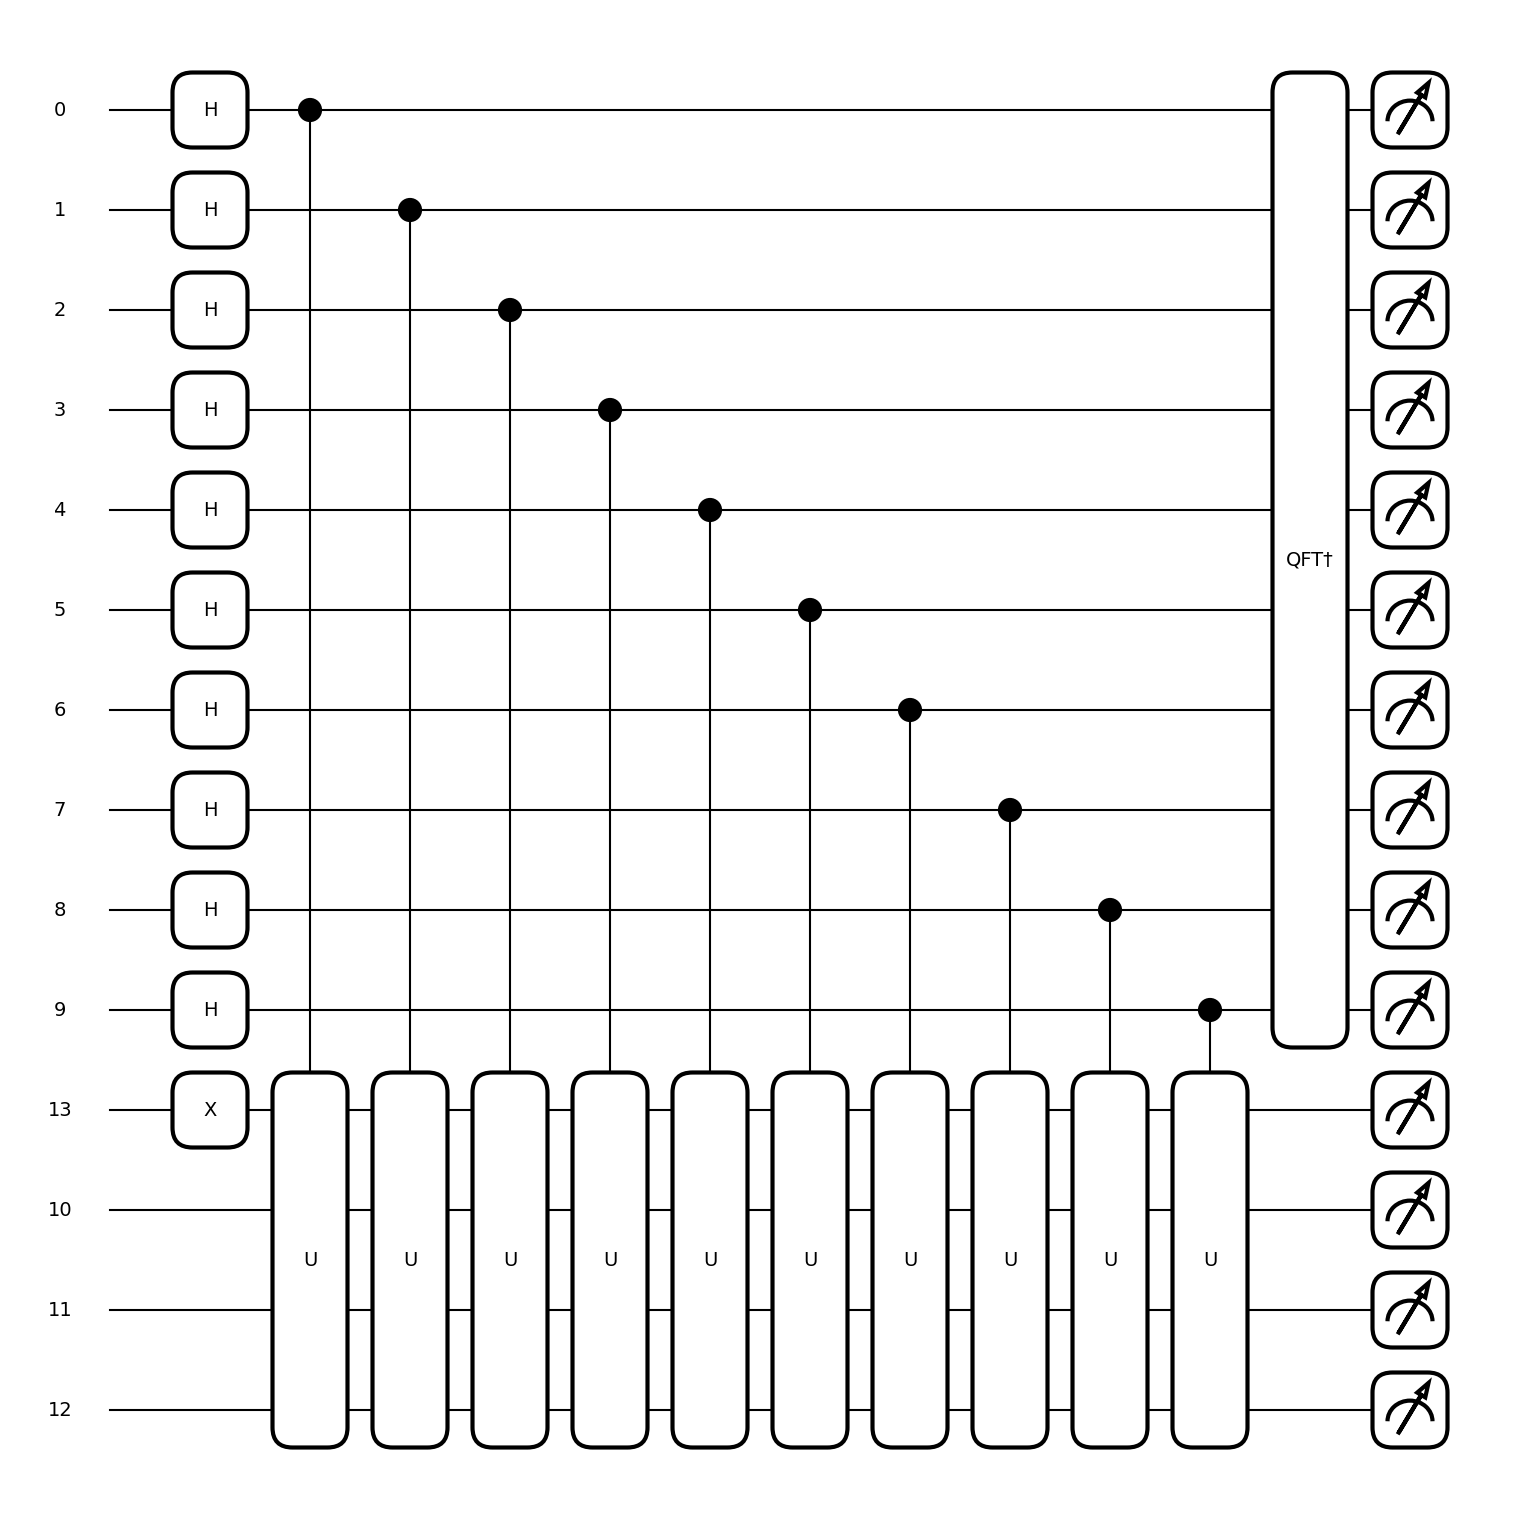

In [248]:
# Draw the circuit using PennyLane's built-in tools
qml.draw_mpl(circuit)()

### Testing Circuit and Checking measurement results

In [12]:
import pennylane as qml
import random
import numpy as np
from math import ceil, log2
from qiskit_ibm_runtime import QiskitRuntimeService

# Define modular exponentiation for Shor's algorithm
def modular_exponentiation(a, N, qubits, target_wires, ancilla_wires):
    """Apply modular exponentiation using controlled unitaries."""
    n = len(target_wires)
    powers = [pow(a, 2**i, N) for i in range(n)]
    for i, power in enumerate(powers):
        binary = bin(power)[2:].zfill(n)
        for j, bit in enumerate(binary):
            if bit == '1':
                qml.CNOT(wires=[qubits[i], target_wires[j]])
                qml.Hadamard(wires=ancilla_wires[i])
                qml.CNOT(wires=[qubits[i], ancilla_wires[i]])

# Define Quantum Fourier Transform (QFT)
def qft(circuit_qubits):
    """Apply Quantum Fourier Transform to qubits."""
    n = len(circuit_qubits)
    for i in range(n):
        qml.Hadamard(wires=circuit_qubits[i])
        for j in range(i + 1, n):
            qml.ControlledPhaseShift(np.pi / (2 ** (j - i)), wires=[circuit_qubits[j], circuit_qubits[i]])

# Define Shor's quantum circuit
def shor_circuit(a: int, N: int, qubits: int) -> qml.QNode:
    """Quantum circuit for Shor's algorithm using error mitigation."""
    n = ceil(log2(N))  # Number of qubits needed
    total_qubits = 2 * n  # Total qubits including ancillas
    
    dev = qml.device("qiskit.aer", wires=total_qubits + n)  # +n for ancilla qubits

    @qml.qnode(dev)
    def circuit():
        # Apply Hadamard gates to the first n qubits
        for i in range(n):
            qml.Hadamard(wires=i)
        
        # Apply Hadamard gates to the ancilla qubits
        ancilla_wires = range(n, 2 * n)
        for i in range(n):
            qml.Hadamard(wires=ancilla_wires[i])

        # Apply modular exponentiation
        modular_exponentiation(a, N, range(n), range(2 * n, 3 * n), ancilla_wires)

        # Apply Quantum Fourier Transform
        qft(range(n))

        # Measure the quantum register
        return qml.sample(wires=range(n))

    return circuit

# Running the Shor's algorithm circuit
a = 7
N = 15
qubits = 4  

# Run the Shor's algorithm circuit
circuit = shor_circuit(a, N, qubits)
result = circuit()

# Print the result
print("Result of the quantum measurement:")
print(result)


Result of the quantum measurement:
[[0 0 1 1]
 [0 1 1 1]
 [1 1 0 0]
 ...
 [0 1 0 1]
 [1 1 1 1]
 [1 0 0 1]]


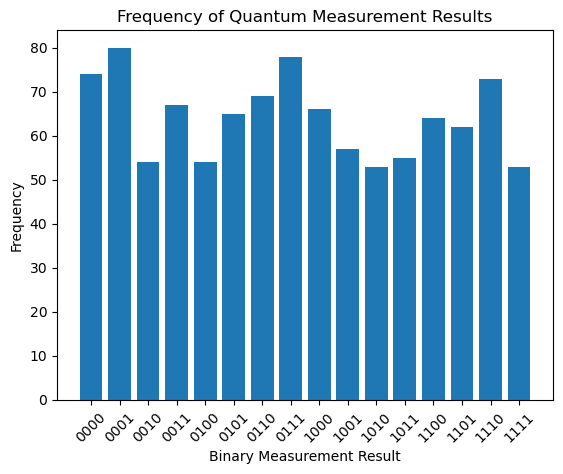

In [13]:
# Convert rows of the matrix to binary strings
binary_strings = [''.join(map(str, row)) for row in result]

# Count the frequency of each unique binary string
unique, counts = np.unique(binary_strings, return_counts=True)

# Plot the frequency distribution
plt.bar(unique, counts)
plt.xlabel('Binary Measurement Result')
plt.ylabel('Frequency')
plt.title('Frequency of Quantum Measurement Results')
plt.xticks(rotation=45)
plt.show()

In [249]:
num_shots = 1000 

# Define a function to execute the circuit and collect results
def test_circuit(params):
    """
    Executes the quantum circuit and collects measurement results.

    Args:
        params: A list containing the parameters for ShorsCircuit.

    Returns:
        list: List of lists, where each sub-list contains measurement outcomes for a single shot.
    """
    results = []
    for _ in range(num_shots):
        result = circuit()
        results.append(result)
    return results

#### Remotely Running the Circuit 

In [ ]:
def ShorsCircuit(N, a):
    uNA = _GetU_NA(a, N)
    nEstimateQUBITS = 4  # Reduced for practical quantum hardware
    nTargetQUBITS = int(np.ceil(np.log2(N)))
    tQ = nEstimateQUBITS + nTargetQUBITS

    dev = qml.device('qiskit.remote', wires=tQ, shots=1024, backend=backend)  # Use Qiskit Aer simulator

    @qml.qnode(dev)
    def circuit():
        estWIRES = range(min(nEstimateQUBITS, tQ))  # Ensure estWIRES are within available wires
        tWAIRES = range(nEstimateQUBITS, min(tQ, 10))  # Ensure target wires don't exceed available wires
        qml.PauliX(wires=tWAIRES[-1])
        
        # Apply Hadamard gates to estimate wires
        for wire in estWIRES:
            qml.Hadamard(wires=wire)
        
        # Apply Controlled-U operations (using CNOT instead of ControlledQubitUnitary)
        for i, wire in enumerate(estWIRES):
            power = 2 ** (nEstimateQUBITS - i - 1)
            
            # Apply controlled unitary (can use CNOT for a simple controlled operation)
            for _ in range(power):
                qml.CNOT(wires=[wire, tWAIRES[-1]])

        # Apply Inverse QFT to estimate wires
        qml.adjoint(qml.QFT)(wires=estWIRES)

        # Measure
        return qml.sample()

    return circuit()
